# AT&T Spams detector

## Loading the data and libraries

In [50]:
# librairies usuelles
import pandas as pd
import numpy as np
import plotly.express as px

# librairies qui vont servir lors du preprocessing textuel
import datetime
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

# librairies pour nos modèles : Tensorflow et Transformers de Hugging Face (pour les modèles pré-entraînés)
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# classes et méthodes de Scikit-Learn pour le préprocessing, le splitting, les métriques, etc...
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# On importe également les plugings params pour Tensorboard, pour le tracking des performances de nos modèles
from tensorboard.plugins.hparams import api as hp

In [51]:
# import vocabulary package
# Charger le modèle de langue anglais
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [52]:
# Load dataset 

data = pd.read_csv('./spam.csv', encoding = 'ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [53]:

# Compter le nombre de valeurs NaN pour chaque colonne
nan_counts = data.isna().sum()

print("Nombre de valeurs NaN par colonne :")
print(nan_counts)

Nombre de valeurs NaN par colonne :
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [54]:
# Supprimer les colonnes qui contiennent plus de 50% de valeurs NaN

data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [55]:
# check class repartition

data['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

## preprocessing

### vocab

In [56]:
# remove poncutuations and convert to lower cases

data['v2_clean'] = data['v2'].apply(lambda s : re.sub(r'[^\w\s]', '', s).lower())
data.head()

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [57]:
# lemmatize 
nlp = spacy.load('en_core_web_md')
data["v2_lemma"] = data["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))    
data.head()


,v1,v2,v2_clean,v2_lemma
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live


In [58]:
## tokenisation


# Créer un objet Tokenizer avec un vocabulaire maximal de 2000 mots et un token "out_of_vocab" pour les mots hors vocabulaire
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="out_of_vocab")

# Adapter le tokenizer aux textes de la colonne 'v2_lemma' de la variable 'data'
tokenizer.fit_on_texts(data['v2_lemma'])

# Obtenir la taille du vocabulaire (nombre de mots) basée sur le nombre maximal de mots spécifié
vocab_size = tokenizer.num_words
print(vocab_size)
# afficher le mapping entre les indices et les mots du vocabulaire construits à partir de la colonne 'v2_lemma'
# Transformer les textes de la colonne 'v2_lemma' en séquences d'entiers en utilisant le tokenizer
data["v2_tokenized"] = tokenizer.texts_to_sequences(data['v2_lemma'])
print(tokenizer.index_word)

# Afficher les premières lignes du DataFrame 'data' pour visualiser les résultats
print(data.head())

2000
{1: 'out_of_vocab', 2: 'u', 3: 'm', 4: '2', 5: 'ur', 6: 'come', 7: 's', 8: '4', 9: 'know', 10: 'ok', 11: 'ltgt', 12: 'free', 13: 'good', 14: 'send', 15: 'like', 16: 'want', 17: 'day', 18: 'ill', 19: 'time', 20: 'love', 21: 'text', 22: 'tell', 23: 'think', 24: 'need', 25: 'txt', 26: 'home', 27: 'lor', 28: 'reply', 29: 'stop', 30: 'sorry', 31: 'r', 32: 'd', 33: 'win', 34: 'mobile', 35: 'today', 36: 'n', 37: 'phone', 38: 'new', 39: 'week', 40: 'later', 41: 'work', 42: 'ask', 43: 'da', 44: 'hi', 45: 'miss', 46: 'ì', 47: 'hope', 48: 'night', 49: 'claim', 50: 'meet', 51: 'wait', 52: 'thing', 53: 'great', 54: 'try', 55: 'oh', 56: 'leave', 57: 'hey', 58: 'dear', 59: 'pls', 60: 'wat', 61: 'happy', 62: 'message', 63: 'number', 64: 'friend', 65: 'feel', 66: 'thank', 67: 'way', 68: 've', 69: 'late', 70: 'prize', 71: 'right', 72: 'msg', 73: 'find', 74: 'pick', 75: 'tomorrow', 76: 'yes', 77: 'let', 78: 'yeah', 79: 'e', 80: '1', 81: 'babe', 82: 'amp', 83: 'sleep', 84: 'min', 85: 'c', 86: 'life',

### train test split

On travaille sur une tâche de classification où les classes sont déséquilibrées (il y a environ 6 fois plus de ham que de spams), donc on utilise la stratification pour s' assurer que la proportion de chaque classe est maintenue dans les ensembles dde train et test.

De plus, les hams représentent 87% des données, alors que les spams représentent seulement 13%. On va donc sélectionner un test size donc on choisit la valeur de l'argument test_size de manière à maintenir la même proportion entre les classes dans l'ensemble de test que dans l'ensemble d'entraînement. Cela garantit que votre modèle est évalué de manière équitable sur toutes les classes

In [59]:
# split train test sets with 0.13 due to 
data_train_test, data_val = train_test_split(data, test_size=0.13, stratify=data['v1'], random_state=2)
print(data_train_test)
print(data_val)

        v1                                                 v2  \
4209   ham  No da:)he is stupid da..always sending like th...   
3507   ham  Camera quite good, 10.1mega pixels, 3optical a...   
3325   ham  Huh so fast... Dat means u havent finished pai...   
2522   ham  Dunno lei... I might b eatin wif my frens... I...   
3933   ham   How come guoyang go n tell her? Then u told her?   
...    ...                                                ...   
1386   ham                        All e best 4 ur exam later.   
1271   ham  If you still havent collected the dough pls le...   
672   spam  Get ur 1st RINGTONE FREE NOW! Reply to this ms...   
2991   ham          K.i did't see you.:)k:)where are you now?   
2658   ham                         Not yet chikku..wat abt u?   

                                               v2_clean  \
4209  no dahe is stupid daalways sending like thisdo...   
3507  camera quite good 101mega pixels 3optical and ...   
3325   huh so fast dat means u havent fini

La valeur cible étant déséquillibrée nous pouvons tenter de réaliser de l'undersampling pour améliiorer  les performances du training.

On effectue une opération de sous-échantillonnage (undersampling) sur un ensemble de données binaire de classification. L'objectif du sous-échantillonnage est de réduire la taille de la classe majoritaire (dans ce cas, la classe "ham") pour équilibrer les proportions entre les classes "ham" et "spam"


In [60]:


def data_under_sampling(data, nb_reduce):
  data_sample_2 = data.loc[data['v1']=='spam',:]
  len_class_sub = len(data_sample_2)
  # extrait toutes les lignes de l'ensemble de données où la colonne 'v1' a la valeur 'ham'.
  # Ensuite, la méthode .sample() est utilisée pour sous-échantillonner cette classe "ham". 
  # Le nombre d'échantillons de la classe "ham" sous-échantillonnée est déterminé en multipliant nb_reduce par la longueur de la classe "spam" calculée précédemment. 
  # Cela réduit la classe majoritaire à un multiple de la taille de la classe minoritaire.
  data_sample_1 = data.loc[data['v1']=='ham',:].sample(nb_reduce * len_class_sub) 
  # Concatène verticalement (axe 0) les deux sous-ensembles de données résultants (le sous-ensemble de données "ham" sous-échantillonné et 
  # le sous-ensemble de données "spam"). Ensuite, .sample(frac=1) est utilisé pour mélanger aléatoirement les lignes de l'ensemble de données résultant, 
  # et .reset_index(drop=True) réinitialise les index des lignes pour créer un nouvel ensemble de données sous-échantillonné et mélangé.".  
  return pd.concat([data_sample_1,data_sample_2], axis=0).sample(frac=1).reset_index(drop=True)

data_red = data_under_sampling(data_train_test, 4)
print(data_red.head())
print(data_red.shape)
print(data_red['v1'].value_counts())

    v1                                                 v2  \
0  ham  No you'll just get a headache trying to figure...   
1  ham      Prabha..i'm soryda..realy..frm heart i'm sory   
2  ham  How's it going? Got any exciting karaoke type ...   
3  ham  I hav almost reached. Call, i m unable to conn...   
4  ham  It is a good thing I'm now getting the connect...   

                                            v2_clean  \
0  no youll just get a headache trying to figure ...   
1              prabhaim sorydarealyfrm heart im sory   
2  hows it going got any exciting karaoke type ac...   
3  i hav almost reached call i m unable to connect u   
4  it is a good thing im now getting the connecti...   

                                            v2_lemma  \
0      ll headache try figure u trust math promise o   
1               prabhaim sorydarealyfrm heart m sory   
2  s exciting karaoke type activity plan m debate...   
3                       hav reach m unable connect u   
4               

In [61]:
# calcule la longueur maximale d'une séquence de tokens dans la colonne 'v2_tokenized' pour avoir une base pour le padding

max_len_sentence = max([len(token) for token in data['v2_tokenized'].to_list()])
max_len_sentence



72

In [62]:
# on applique le padding 
v2_pad_train = tf.keras.preprocessing.sequence.pad_sequences(data_red['v2_tokenized'], padding="post", maxlen=max_len_sentence)
v2_pad_val = tf.keras.preprocessing.sequence.pad_sequences(data_val['v2_tokenized'], padding="post", maxlen=max_len_sentence)

### target prepocessing

In [63]:
preprocessor_y = LabelEncoder()

In [64]:

y_train_test = preprocessor_y.fit_transform(data_red['v1'])
y_val = preprocessor_y.transform(data_val['v1'])


Après avoir appliqué les prétraitements appropriés à la fois sur l'ensemble de données sous-échantillonné combinant les données d'entraînement et de test d'une part, et sur l'ensemble de données de validation d'autre part, nous pouvons procéder à une deuxième division pour créer les ensembles distincts d'entraînement et de test. Tout comme lors de la première division, nous utilisons une stratification pour garantir que les proportions des classes cibles sont maintenues dans les deux ensembles, assurant ainsi une répartition équilibrée des données de chaque classe dans les ensembles d'entraînement et de test.

In [65]:
x_train, x_test, y_train, y_test = train_test_split(v2_pad_train, y_train_test, test_size=0.15, stratify=y_train_test, random_state=2)

On prépare les données d'entraînement et de test en les transformant en objets tf.data.Dataset, en les mélangeant (pour les données d'entraînement), en les divisant en lots de taille spécifiée, puis en extrayant et affichant un échantillon de l'ensemble de test pour vérification. Ces étapes sont  utilisées pour l'entraînement de modèles d'apprentissage automatique avec TensorFlow.

In [66]:
BATCH_SIZE = 64
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
test_batch = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

print('Preprocessing done --- extract of test_batch : ')
for sentence, target in test_batch.take(1):
  print(sentence, target)

Preprocessing done --- extract of test_batch : 
tf.Tensor(
[[   1    9   19 ...    0    0    0]
 [   1   62 1551 ...    0    0    0]
 [  14    5  404 ...    0    0    0]
 ...
 [  15   23    7 ...    0    0    0]
 [  57   45 1756 ...    0    0    0]
 [  18    2 1321 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0], shape=(64,), dtype=int64)


2023-10-05 12:04:08.994361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [488]
	 [[{{node Placeholder/_1}}]]


On utilise TensorFlow et le module tf.data pour optimiser la gestion des données lors de l'entraînement d'un modèle d'apprentissage automatique. POur cela on utilise les méthodes cache() et prefetch() pour améliorer l'efficacité du chargement des données. 

In [67]:
# On définit la constante AUTOTUNE en utilisant une valeur spéciale pour indiquer à TensorFlow de déterminer automatiquement la meilleure valeur 
# pour certains paramètres afin d'optimiser les performances.
# Dans ce contexte, AUTOTUNE sera utilisé pour déterminer la taille de la mémoire tampon (buffer size) dans les étapes suivantes
AUTOTUNE = tf.data.AUTOTUNE 

train_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
test_batch = train_batch.cache().prefetch(buffer_size=AUTOTUNE)
     

## Test du modèle 1

### Architecture

Nous créons ici un modèle de base initial pour aborder le problème et obtenir une base à partir de laquelle nous pourrons évaluer d'autres modèles. Pour l'instant, le modèle ne comprend pas de couches de réseaux de neurones récurrents (RNN). Il commence par une couche d'embedding en entrée qui traite les tokens un par un dans chaque phrase. Ensuite, le Global Average Pooling agrège les valeurs de tous les tokens de la phrase, sans tenir compte de leur ordre séquentiel. Les valeurs résultantes des 128 neurones de la couche d'embedding sont ensuite transmises à trois couches successives de neurones denses avec une fonction d'activation simple appelée "Rectified Linear Unit" (ReLU). Enfin, le dernier neurone de la dernière couche utilise une fonction d'activation sigmoid, adaptée à la classification binaire classique.

In [68]:


model_1 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],],name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])
model_1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 128)           256128    
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 8)                 264       
                                                      

### compilation

On créé une fonction Python nommée compile_and_log qui compile un modèle TensorFlow, configure son processus d'entraînement, et configure des callbacks pour enregistrer des journaux d'entraînement, y compris des métriques et des hyperparamètres. 

In [69]:
def compile_and_log(model, model_name='default', architecture={}):
  # definition de l'optimiseur - on utilise Adam()
  optimizer= tf.keras.optimizers.Adam()
  # lors de la compilation, pour la loss on prend
  model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
  log_dir="logs/fit/" + model_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  hparams_callback = hp.KerasCallback(log_dir, architecture)
  print (f"{model} logged with name : {model_name}...")
  return tensorboard_callback, hparams_callback

In [70]:
tensorboard_callback, hparams_callback = compile_and_log(model_1, "Simple Multi-Layers Denses", {
                                                                                            'dim_embedding':128,
                                                                                            'nb_dense_units':105,
                                                                                            'dropout':0.2})

<keras.engine.sequential.Sequential object at 0x7f9c70ec47f0> logged with name : Simple Multi-Layers Denses...


### training

In [71]:
model_1.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=test_batch)

Epoch 1/20


2023-10-05 12:04:09.434563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2762]
	 [[{{node Placeholder/_1}}]]
2023-10-05 12:04:09.436712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2762]
	 [[{{node Placeholder/_1}}]]


41/44 [==========================>...] - ETA: 0s - loss: 0.5612 - accuracy: 0.7999 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-10-05 12:04:13.695588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2762]
	 [[{{node Placeholder/_1}}]]
2023-10-05 12:04:13.696929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2762]
	 [[{{node Placeholder/_1}}]]


44/44 [==============================] - 5s 41ms/step - loss: 0.5585 - accuracy: 0.7987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4624 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 1s 26ms/step - loss: 0.4434 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4102 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 25ms/step - loss: 0.3372 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2494 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 1s 27ms/step - loss: 0.2183 - accuracy: 0.9131 - precision: 0.9382 - recall: 0.6051 - val_loss: 0.1847 - val_accuracy: 0.9613 - val_precision: 0.9532 - val_recall: 0.8478
Epoch 5/20
44/44 [==============================] - 1s 32ms/step - loss

44/44 [==============================] - 2s 49ms/step - loss: 0.0118 - accuracy: 0.9986 - precision: 0.9982 - recall: 0.9946 - val_loss: 0.0100 - val_accuracy: 0.9982 - val_precision: 0.9982 - val_recall: 0.9928
Epoch 15/20
44/44 [==============================] - 2s 44ms/step - loss: 0.0110 - accuracy: 0.9978 - precision: 0.9982 - recall: 0.9909 - val_loss: 0.0139 - val_accuracy: 0.9964 - val_precision: 0.9857 - val_recall: 0.9964
Epoch 16/20
44/44 [==============================] - 2s 44ms/step - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9982 - recall: 0.9909 - val_loss: 0.0124 - val_accuracy: 0.9964 - val_precision: 0.9857 - val_recall: 0.9964
Epoch 17/20
44/44 [==============================] - 2s 34ms/step - loss: 0.0127 - accuracy: 0.9975 - precision: 0.9982 - recall: 0.9891 - val_loss: 0.0089 - val_accuracy: 0.9975 - val_precision: 0.9928 - val_recall: 0.9946
Epoch 18/20
44/44 [==============================] - 1s 34ms/step - loss: 0.0118 - accuracy: 0.9957 - precision: 0.9

### Analysis

Les résultats des epochs suivantes montrent une amélioration significative de la performance du modèle. Par exemple, au fur et à mesure que les epochs progressent, la loss diminue, la précision augmente, le rappel augmente, et l'accuracy générale du modèle s'améliore sur l'ensemble de validation.

Cela indique que le modèle s'améliore progressivement au fil de l'entraînement, apprenant à mieux ajuster ses prédictions aux données. Il est probable que les deux premières epochs aient été initiales, avec des valeurs inhabituellement basses pour la précision et le rappel, mais le modèle s'est ajusté par la suite.

Ces résultats montrent que le modèle commence à apprendre à partir des données d'entraînement et devient plus performant au fur et à mesure que l'entraînement progresse. Les valeurs de la loss, de la précision et du rappel indiquent que le modèle se rapproche d'une bonne performance pour la tâche de classification binaire

A présent on utilise une fonction qui permet d'ajuster le seuil pour voir comment il affecte la classification de notre modèle. cela servira à équilibrer la précision et le rappel dans cette tâche de classification binaire en ajustant le seuil de décision pour obtenir le meilleur compromis entre ces deux métriques.

In [72]:
def predictions_singleton_to_binary(model, tresh, x_val, y_val):
  y_true = y_val
  y_pred = np.where(model.predict(x_val) > tresh, 1, 0)
  return y_true, y_pred
     

In [73]:
# Affichage des matrices de confusion

def display_matrix_and_scores(y_true, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  print(f'Accuracy : {accuracy_score(y_true,y_pred)}')
  print(f'Precision : {precision_score(y_true,y_pred)}')
  print(f'Recall : {recall_score(y_true,y_pred)}')

In [74]:
y_true, y_pred = predictions_singleton_to_binary(model_1, 0.5, v2_pad_val, y_val)

23/23 [==============================] - 1s 6ms/step


Accuracy : 0.9848275862068966
Precision : 0.9574468085106383
Recall : 0.9278350515463918


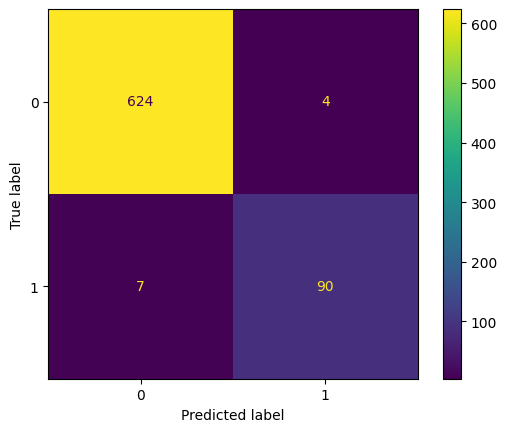

In [75]:
display_matrix_and_scores(y_true, y_pred)

Les résultats montrent que notre modèle a une très bonne précision globale (accuracy élevée), une précision élevée pour les prédictions positives (precision élevée), et il est également capable de rappeler la grande majorité des exemples positifs (recall élevé). Cela suggère que le modèle est performant dans la tâche de classification, mais il est toujours important de considérer le contexte de votre problème pour interpréter les résultats. Dans notre cas, notre tâche nécessite de minimiser les faux négatifs (c'est-à-dire les cas où le modèle ne parvient pas à prédire un spam), on pourrait vouloir ajuster le seuil de décision pour augmenter le rappel au détriment de la précision.

## Modèle RNN

Nous passons maintenant à la création de modèles incluant des couches de RNN (Réseaux de Neurones Récursifs). Dans cette première approche, nous adoptons une configuration plutôt classique. Tout d'abord, nous conservons l'Embedding avec le même nombre de dimensions qu'auparavant (128). Ensuite, nous utilisons des couches de RNN qui traitent les tokens un par un en maintenant une trace des tokens précédents, permettant ainsi de conserver une "mémoire" de la phrase. La deuxième et dernière couche de RNN renvoie uniquement le résultat final des tokens (et non la séquence complète), ce résultat est transmis à une couche Dense composée de 8 neurones. Enfin, nous avons toujours notre unique neurone chargé de la classification des deux classes, tout comme dans le premier modèle.



In [77]:


model_2 = tf.keras.Sequential([        
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],],name="embedding"),
                  tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                  tf.keras.layers.SimpleRNN(units=32, return_sequences=False),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(8, activation='relu'),
                  tf.keras.layers.Dropout(0.1),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])
model_2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 128)           256128    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 72, 64)            12352     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 8)                 264       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                

On appelle la fonction compile_and_log pour compiler et enregistrer notre modèle de réseau de neurones récurrents (RNN) dans TensorBoard, tout en spécifiant certaines configurations pour le modèle.

In [78]:


tensorboard_callback, hparams_callback = compile_and_log(model_2, "Simple Multi-Layers RNN with final Dense", {
                                                                                            'dim_embedding':128,
                                                                                            'nb_rnn_units':96,
                                                                                            'nb_units_dense':9,
                                                                                            'dropout':0.1})
     


<keras.engine.sequential.Sequential object at 0x7f9cec81f550> logged with name : Simple Multi-Layers RNN with final Dense...


In [79]:
model_2.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=test_batch)
     

Epoch 1/20
44/44 [==============================] - 18s 208ms/step - loss: 0.5324 - accuracy: 0.7940 - precision: 0.2927 - recall: 0.0217 - val_loss: 0.5018 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 7s 160ms/step - loss: 0.5175 - accuracy: 0.7998 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5048 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 8s 189ms/step - loss: 0.5156 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5045 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 8s 179ms/step - loss: 0.5153 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5016 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
44/44 [=============================

#### Analyse

Au départ, la précision et le rappel sont très bas, ce qui suggère que le modèle ne fait pas un bon travail de classification.
Au fil des époques, la précision sur l'ensemble de validation reste très basse, ce qui peut indiquer un problème avec le modèle ou les données.
La précision sur l'ensemble d'entraînement augmente progressivement, mais elle est toujours relativement basse. La précision sur l'ensemble d'entraînement atteint un pic d'environ 0,7978, mais elle stagne ensuite.
La perte diminue progressivement jusqu'à atteindre un plateau.

IL y semble y avoir un impat du problème de déséquilibre de classe dans les données  car la précision et le rappel sur l'ensemble de validation sont très bas. Le modèle semble avoir du mal à prédire correctement les exemples positifs.

Il pourrait être utile de vérifier les données d'entraînement, de s'assurer qu'elles sont équilibrées et de considérer des techniques de rééchantillonnage ou de pondération de classe pour améliorer la performance du modèle. De plus, il serait bénéfique d'explorer d'autres métriques d'évaluation, telles que la courbe ROC-AUC, pour obtenir une image plus complète de la performance du modèle.


In [80]:
y_true, y_pred = predictions_singleton_to_binary(model_2, 0.5, v2_pad_val, y_val)

23/23 [==============================] - 3s 55ms/step


Accuracy : 0.8717241379310345
Precision : 0.527027027027027
Recall : 0.4020618556701031


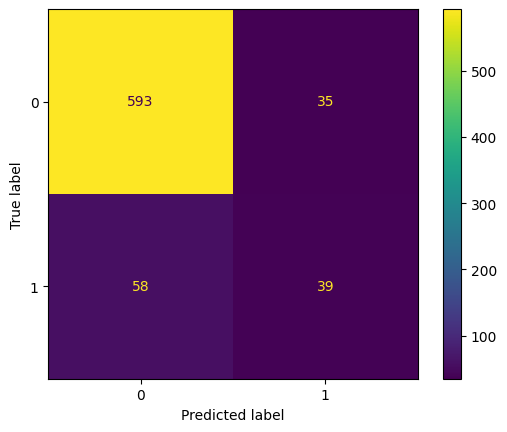

In [81]:
display_matrix_and_scores(y_true, y_pred)

## Modèle LSTM

Pour éviter les fuites nous allons changer les couches de notre modèle ^^ en utilisant un modèle séquentiel utilisant des couches LSTM (Long Short-Term Memory), qui sont des variantes plus puissantes des RNN et qui sont particulièrement adaptées à la modélisation de séquences.

In [82]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 128, input_shape=[x_train.shape[1],]),
    tf.keras.layers.LSTM(units=64, return_sequences=True),  # Utilisation de LSTM au lieu de SimpleRNN
    tf.keras.layers.LSTM(units=32),  # Une seule couche LSTM sans return_sequences=True
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.summary()

2023-10-05 16:27:12.833437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 16:27:12.842970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 16:27:12.850001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-10-05 16:27:13.848409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 16:27:13.856570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 16:27:13.862912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 embedding (Embedding)       (None, 72, 128)           256128    
                                                                 
 lstm (LSTM)                 (None, 72, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 8)                 264       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 318,225
Trainable params: 318,225
Non-trainable params: 0
____

In [83]:
tensorboard_callback, hparams_callback = compile_and_log(model_3, "LSTM Model", {
    'dim_embedding': 128,
    'nb_lstm_units_1': 64,  # Nombre d'unités LSTM dans la première couche LSTM
    'nb_lstm_units_2': 32,  # Nombre d'unités LSTM dans la deuxième couche LSTM
    'nb_units_dense': 8,    # Nombre d'unités dans la couche Dense
    'dropout': 0.1          # Taux de dropout
})


<keras.engine.sequential.Sequential object at 0x7f9d479762f0> logged with name : LSTM Model...


In [84]:
model_3.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=test_batch)
     

Epoch 1/20


2023-10-05 17:14:24.676014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 17:14:24.683497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 17:14:24.689339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/44 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.7886 - precision: 0.2333 - recall: 0.0254

2023-10-05 17:14:52.229794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-05 17:14:52.238817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-05 17:14:52.243575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/44 [==============================] - 35s 436ms/step - loss: 0.5419 - accuracy: 0.7886 - precision: 0.2333 - recall: 0.0254 - val_loss: 0.5051 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 16s 363ms/step - loss: 0.5105 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5030 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 16s 373ms/step - loss: 0.5101 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5022 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 18s 410ms/step - loss: 0.5092 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5019 - val_accuracy: 0.8001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
44/44 [==============================] - 16s

Le modèle a été capable de minimiser la perte sur l'ensemble d'entraînement, mais il semble avoir des problèmes pour effectuer des prédictions positives correctes, ce qui se reflète dans les métriques de précision et de rappel. Il pourrait être nécessaire d'explorer davantage le modèle, l'ensemble de données ou les paramètres d'entraînement pour améliorer ces performances.

# Conclusion et prespectives